In [1]:
import os
import numpy as np
import torch
import torchio as tio
import torchio.transforms as transforms
import matplotlib.pyplot as plt
import h5py
import math
from scipy.fft import fftn, ifftn, fftshift, ifftshift
from misalign.data.IXI_datamodule import IXIDataModule
from misalign.draw import blend_and_transpose
import nibabel as nib
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def show_img(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=200)
    plt.xticks([])
    plt.yticks([])
    plt.show()

c:\Users\NUGURI\anaconda3\envs\misalign\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Sub 5
slice = 50

# Label T1
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_lv5_50A_T1/runs/2023-08-13_01-03-33/results/b_10.nii.gz'
nii_image = nib.load(nii_file_path)
raw_T1 = nii_image.get_fdata()
raw_T1 = np.transpose(raw_T1, (1,0,2))
raw_T1 = np.flipud(raw_T1)
raw_T1 = np.fliplr(raw_T1)

# Label T2
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_lv5_50A_T1/runs/2023-08-13_01-03-33/results/a_10.nii.gz'
nii_image = nib.load(nii_file_path)
raw_T2 = nii_image.get_fdata()
raw_T2 = np.transpose(raw_T2, (1,0,2))
raw_T2 = np.flipud(raw_T2)
raw_T2 = np.fliplr(raw_T2)

# Base T1
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_lv5_50A_T1/runs/2023-08-13_01-03-33/results/preds_a_10.nii.gz'
nii_image = nib.load(nii_file_path)
Base_T1 = nii_image.get_fdata()
Base_T1 = np.transpose(Base_T1, (1,0,2))
Base_T1 = np.flipud(Base_T1)
Base_T1 = np.fliplr(Base_T1)

# Base+RW T1
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_RW_lv5_50A_T1/runs/2023-08-13_01-03-46/results/preds_a_10.nii.gz'
nii_image = nib.load(nii_file_path)
Base_RW_T1 = nii_image.get_fdata()
Base_RW_T1 = np.transpose(Base_RW_T1, (1,0,2))
Base_RW_T1 = np.flipud(Base_RW_T1)
Base_RW_T1 = np.fliplr(Base_RW_T1)

# Base+RW+CX T1
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_RW_CX_lv5_50A_T1/runs/2023-08-13_01-03-49/results/preds_a_10.nii.gz'
nii_image = nib.load(nii_file_path)
Base_RW_CX_T1 = nii_image.get_fdata()
Base_RW_CX_T1 = np.transpose(Base_RW_CX_T1, (1,0,2))
Base_RW_CX_T1 = np.flipud(Base_RW_CX_T1)
Base_RW_CX_T1 = np.fliplr(Base_RW_CX_T1)

# Base+RW+CX+RC T1
nii_file_path = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Ablation_Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0.5_D0/Ablation_Base_RW_CX_RC_lv5_50A_T1/runs/2023-08-13_01-03-51/results/preds_a_10.nii.gz'
nii_image = nib.load(nii_file_path)
Base_RW_CX_RC_T1 = nii_image.get_fdata()
Base_RW_CX_RC_T1 = np.transpose(Base_RW_CX_RC_T1, (1,0,2))
Base_RW_CX_RC_T1 = np.flipud(Base_RW_CX_RC_T1)
Base_RW_CX_RC_T1 = np.fliplr(Base_RW_CX_RC_T1)

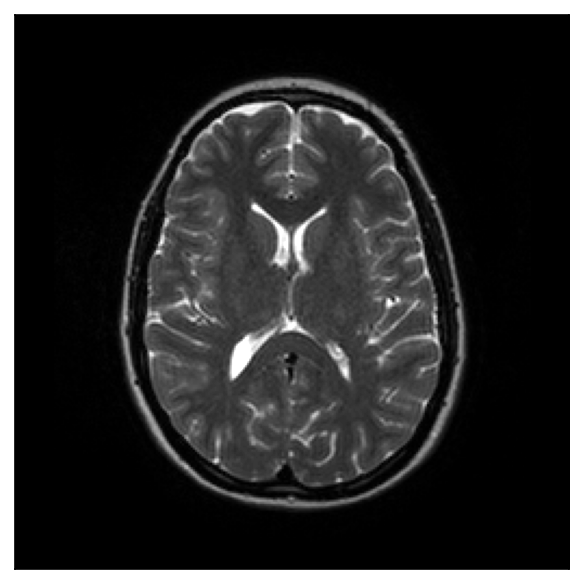

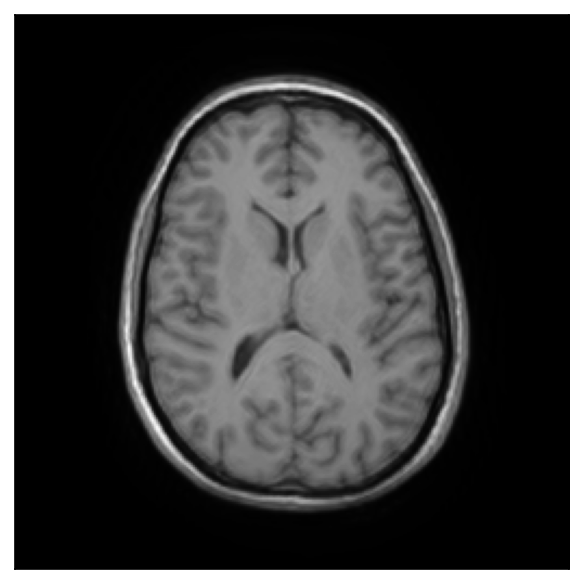

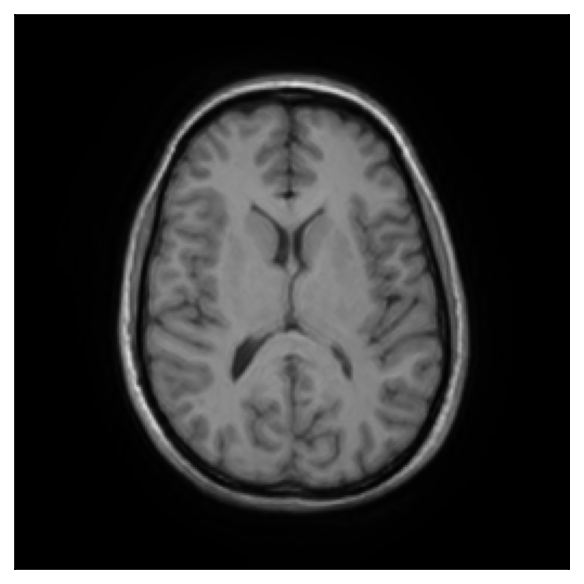

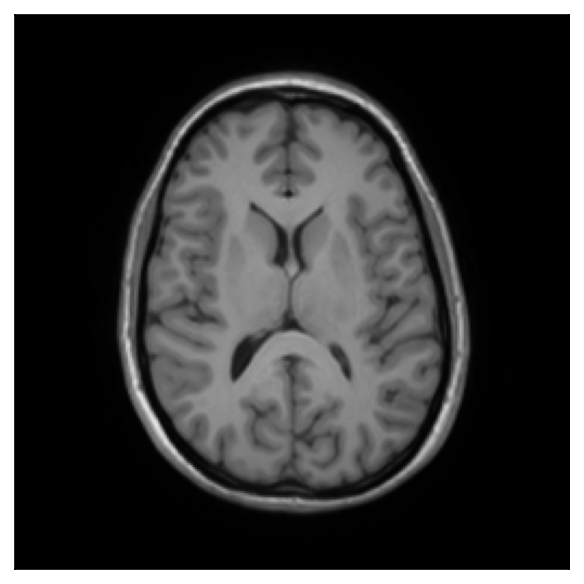

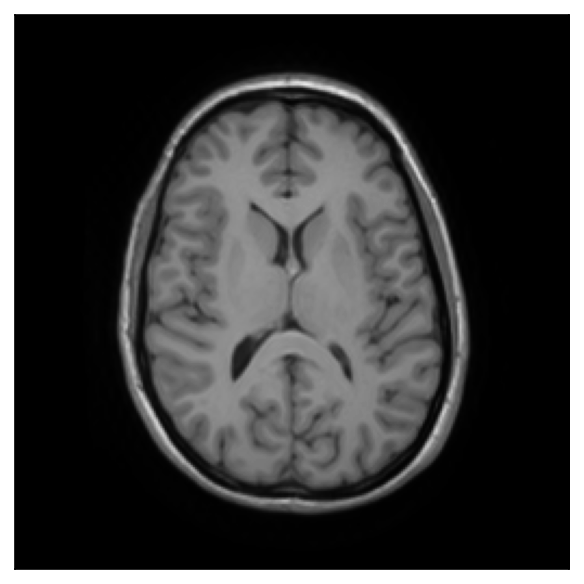

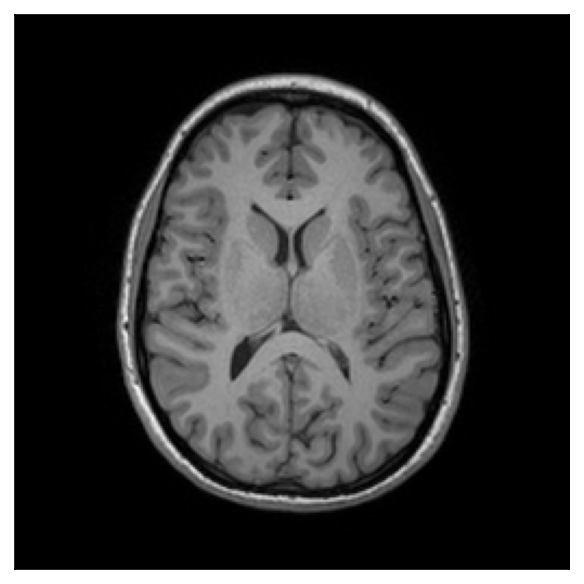

In [40]:
show_img(raw_T2[:,:,slice])
show_img(Base_T1[:,:,slice])
show_img(Base_RW_T1[:,:,slice])
show_img(Base_RW_CX_T1[:,:,slice])
show_img(Base_RW_CX_RC_T1[:,:,slice])
show_img(raw_T1[:,:,slice])

In [42]:
data_range = 1

raw_T1_1z = torch.tensor(raw_T1[:,:,slice]/255).unsqueeze(0).unsqueeze(0).float()
Base_T1_1z = torch.tensor(Base_T1[:,:,slice]/255).unsqueeze(0).unsqueeze(0).float()
Base_RW_T1_1z = torch.tensor(Base_RW_T1[:,:,slice]/255).unsqueeze(0).unsqueeze(0).float()
Base_RW_CX_T1_1z = torch.tensor(Base_RW_CX_T1[:,:,slice]/255).unsqueeze(0).unsqueeze(0).float()
Base_RW_CX_RC_T1_1z = torch.tensor(Base_RW_CX_RC_T1[:,:,slice]/255).unsqueeze(0).unsqueeze(0).float()

ssim_metric = StructuralSimilarityIndexMeasure(data_range=data_range)
psnr_metric = PeakSignalNoiseRatio(data_range=data_range)

Base_SSIM = ssim_metric(raw_T1_1z, Base_T1_1z)
Base_PSNR = psnr_metric(raw_T1_1z, Base_T1_1z)

Base_RW_SSIM = ssim_metric(raw_T1_1z, Base_RW_T1_1z)
Base_RW_PSNR = psnr_metric(raw_T1_1z, Base_RW_T1_1z)

Base_RW_CX_SSIM = ssim_metric(raw_T1_1z, Base_RW_CX_T1_1z)
Base_RW_CX_PSNR = psnr_metric(raw_T1_1z, Base_RW_CX_T1_1z)

Base_RW_CX_RC_SSIM = ssim_metric(raw_T1_1z, Base_RW_CX_RC_T1_1z)
Base_RW_CX_RC_PSNR = psnr_metric(raw_T1_1z, Base_RW_CX_RC_T1_1z)

print("Base SSIM:", Base_SSIM)
print("Base PSNR:", Base_PSNR)

print("Base_RW SSIM:", Base_RW_SSIM)
print("Base_RW PSNR:", Base_RW_PSNR)

print("Base_RW_CX SSIM:", Base_RW_CX_SSIM)
print("Base_RW_CX PSNR:", Base_RW_CX_PSNR)

print("Base_RW_CX_RC SSIM:", Base_RW_CX_RC_SSIM)
print("Base_RW_CX_RC PSNR:", Base_RW_CX_RC_PSNR)

Base SSIM: tensor(0.8747)
Base PSNR: tensor(27.4494)
Base_RW SSIM: tensor(0.8701)
Base_RW PSNR: tensor(28.1201)
Base_RW_CX SSIM: tensor(0.9034)
Base_RW_CX PSNR: tensor(28.6997)
Base_RW_CX_RC SSIM: tensor(0.8924)
Base_RW_CX_RC PSNR: tensor(28.1082)
